In [1]:
### imporitng lib

In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from sklearn.preprocessing import LabelEncoder
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from causalnex.inference import InferenceEngine

In [4]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))


## preparing the data for learning 

In [50]:
df_tripOrder = pd.read_csv("../data/newCleanData.csv")

In [51]:
colu = ['Unnamed: 0', 'Trip_Origin_lat','Trip_Origin_lng','Trip_Origin_lng', 'Trip_Destn_lat', 'Trip_Destn_lng', 'id', 'order_id','driver_id', 'lat', 'lng']

In [52]:
df_tripOrder.drop(colu, inplace = True, axis =1)

In [53]:
df_tripOrder.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,accepted,0,0
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0


In [71]:
df_tripOrder.to_csv('../data/forCusalGraph.csv', index =False)

In [76]:
# copy the data
struct_data = df_tripOrder.copy()

**The data is resource intensive and random subdata would be used to construct the causal graph.**

In [77]:
struct_data.shape

(1555718, 10)

In [78]:
# identifying cattgorical variable
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time', 'driver_action']


In [79]:
# changing to numeric values 
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])
struct_data.head(5)

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,11676,3785,275,123,20.98,217.00,0,0,0
1,392001,11676,3785,275,123,20.98,217.00,1,0,0
2,392001,11676,3785,275,123,20.98,217.00,1,0,0
3,392001,11676,3785,275,123,20.98,217.00,1,0,0
4,392001,11676,3785,275,123,20.98,217.00,1,0,0


In [93]:
# initializing the structural model
sm = StructureModel()
# selecting the dataset used to construct the causal graph


In [174]:
x_selected = struct_data.head(100000)

In [175]:
# renaming couluns  
dict = {'Trip Origin': 'Trip_Origin',
        'Trip ID': 'Order_id',
        'Trip Destination': 'Trip_Dest',
        'Trip Start Time': 'Trip_Start_Time',
        'Trip End Time': 'Trip_End_Time'}
 
# call rename () method
x_selected.rename(columns=dict,
          inplace=True)

In [176]:
sm = from_pandas(x_selected)

**and visualise the learned StructureModel using the plot function.**

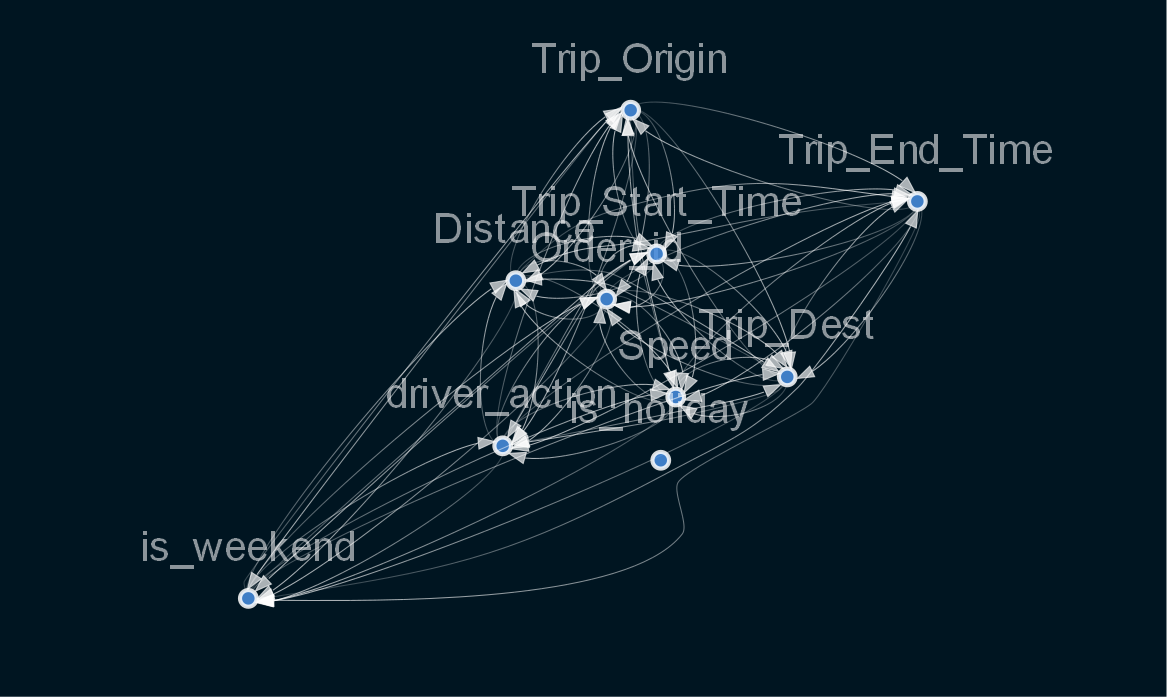

In [178]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

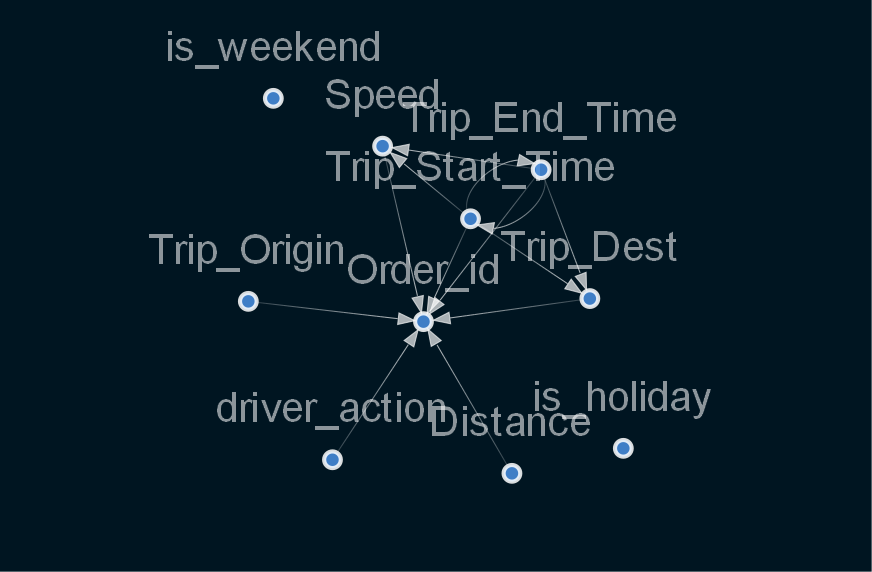

In [179]:
## removing edges with low threshold
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

in this structure, we can see that there are some relationships that appear intuitively correct:

- driver_action affects Order_id - orders may be accpeted or rejected by the drivers.

- distance affects  Order_id - the distance between the driver location and customer location may affect the fulfillment of orders. Sometimes if the distance is large, the order might rejected.

### Stablity of causal graph

In [180]:
def jaccard_similarity(g,h):
    i = set(g).intersection(h)
    return round(len(i)/(len(g) + len(h) - len(i)),3)

#### checking 60%

In [187]:
portion = int(x_selected.shape[0] *.60)
x_portion = x_selected.head(portion)
#sm_60 = from_pandas(x_portion, )
#jacard_similartiy(sm, sm_60)

CPU times: total: 1min 51s
Wall time: 32.1 s


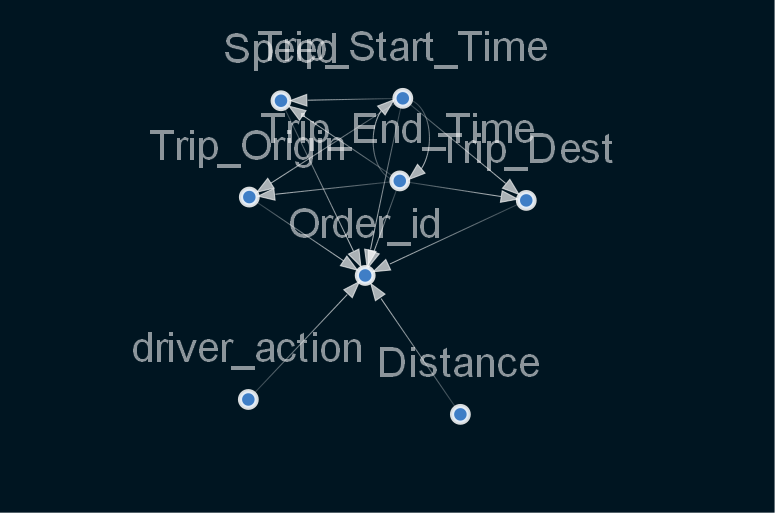

In [188]:
%%time
sm1 = from_pandas(x_portion)
sm1.remove_edges_below_threshold(0.8)
# sm1 = sm1.get_largest_subgraph()
# vs.vis_sm(sm1)

sm1 = sm1.get_largest_subgraph()
viz = plot_structure(
    sm1,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [189]:
print(sm1.edges)

[('Trip_Origin', 'Order_id'), ('Trip_Dest', 'Order_id'), ('Trip_Start_Time', 'Order_id'), ('Trip_Start_Time', 'Trip_Origin'), ('Trip_Start_Time', 'Trip_Dest'), ('Trip_Start_Time', 'Trip_End_Time'), ('Trip_Start_Time', 'Speed'), ('Trip_End_Time', 'Order_id'), ('Trip_End_Time', 'Trip_Origin'), ('Trip_End_Time', 'Trip_Dest'), ('Trip_End_Time', 'Trip_Start_Time'), ('Trip_End_Time', 'Speed'), ('Distance', 'Order_id'), ('Speed', 'Order_id'), ('driver_action', 'Order_id')]


**80%**

In [190]:
portion = int(x_selected.shape[0] *.80)
x_portion = x_selected.head(portion)

CPU times: total: 3min 33s
Wall time: 57.9 s


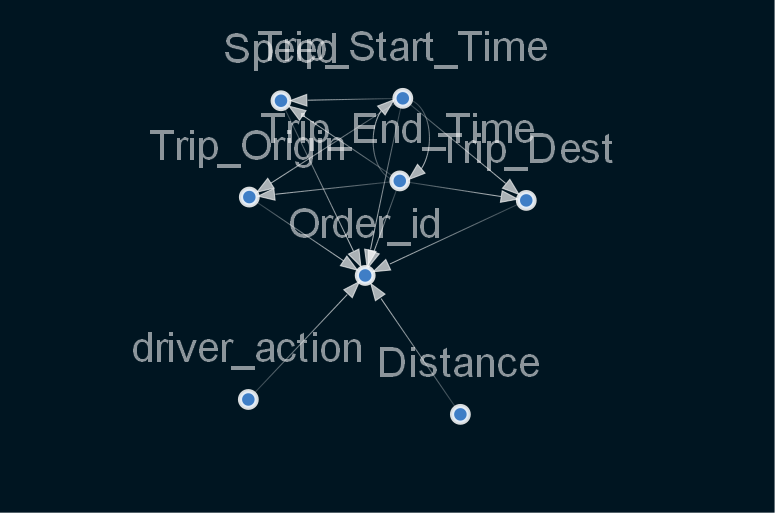

In [191]:
%%time
sm2 = from_pandas(x_portion)
sm2.remove_edges_below_threshold(0.8)
# sm1 = sm1.get_largest_subgraph()
# vs.vis_sm(sm1)

sm2 = sm1.get_largest_subgraph()
viz = plot_structure(
    sm2,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [192]:
print(sm2.edges)

[('Trip_Origin', 'Order_id'), ('Trip_Dest', 'Order_id'), ('Trip_Start_Time', 'Order_id'), ('Trip_Start_Time', 'Trip_Origin'), ('Trip_Start_Time', 'Trip_Dest'), ('Trip_Start_Time', 'Trip_End_Time'), ('Trip_Start_Time', 'Speed'), ('Trip_End_Time', 'Order_id'), ('Trip_End_Time', 'Trip_Origin'), ('Trip_End_Time', 'Trip_Dest'), ('Trip_End_Time', 'Trip_Start_Time'), ('Trip_End_Time', 'Speed'), ('Distance', 'Order_id'), ('Speed', 'Order_id'), ('driver_action', 'Order_id')]


**90%**

In [193]:
portion = int(x_selected.shape[0] *.9)
x_portion = x_selected.head(portion)

CPU times: total: 3min 33s
Wall time: 53.7 s


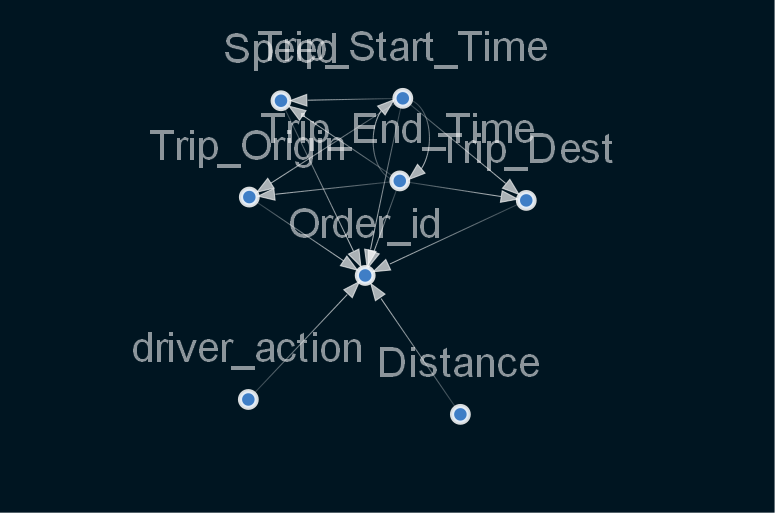

In [194]:
%%time
sm3 = from_pandas(x_portion)
sm3.remove_edges_below_threshold(0.8)
# sm1 = sm1.get_largest_subgraph()
# vs.vis_sm(sm1)

sm3 = sm1.get_largest_subgraph()
viz = plot_structure(
    sm3,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [196]:
print(sm3.edges)

[('Trip_Origin', 'Order_id'), ('Trip_Dest', 'Order_id'), ('Trip_Start_Time', 'Order_id'), ('Trip_Start_Time', 'Trip_Origin'), ('Trip_Start_Time', 'Trip_Dest'), ('Trip_Start_Time', 'Trip_End_Time'), ('Trip_Start_Time', 'Speed'), ('Trip_End_Time', 'Order_id'), ('Trip_End_Time', 'Trip_Origin'), ('Trip_End_Time', 'Trip_Dest'), ('Trip_End_Time', 'Trip_Start_Time'), ('Trip_End_Time', 'Speed'), ('Distance', 'Order_id'), ('Speed', 'Order_id'), ('driver_action', 'Order_id')]


In [195]:
jaccard_similarity(sm2.edges, sm1.edges)

1.0

In [197]:
jaccard_similarity(sm3.edges, sm2.edges)

1.0

**The jaccard_similarity shows no difference between the causal graphs**

In [127]:
# similarity
jaccard_similarity(sm3.edges, sm4.edges)

1.0

In [202]:
# removing not acyclic stucture
sm3.remove_edge('Trip_Start_Time', 'Trip_End_Time')
sm3.remove_edge('Trip_End_Time','Trip_Start _Time')

## Fitting the Conditional Distribution of the Bayesian Network

In [201]:
bn = BayesianNetwork(sm3)

### Discretising Numeric Features

In [204]:
discretised_data = x_selected.copy()

In [205]:
discretised_data.columns

Index(['Order_id', 'Trip_Origin', 'Trip_Dest', 'Trip_Start_Time',
       'Trip_End_Time', 'Distance', 'Speed', 'driver_action', 'is_weekend',
       'is_holiday'],
      dtype='object')

In [206]:
# discretised_data["driver_action"] = Discretiser(method="fixed",
#                           numeric_split_points=[1, 10]).transform(discretised_data["driver_action"].values)
discretised_data["Order_id"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["Order_id"].values)
discretised_data["Trip_Origin"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["Trip_Origin"].values)
discretised_data["Trip_Dest"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["Trip_Dest"].values)
discretised_data["Trip_Start_Time"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["Trip_Start_Time"].values)
discretised_data["Trip_End_Time"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["Trip_End_Time"].values)
discretised_data["Distance"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["Distance"].values)
discretised_data["Speed"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["Speed"].values)

In [207]:
discretised_data.head()

,Order_id,Trip_Origin,Trip_Dest,Trip_Start_Time,Trip_End_Time,Distance,Speed,driver_action,is_weekend,is_holiday
0,1,1,1,1,1,1,1,0,0,0
1,1,1,1,1,1,1,1,1,0,0
2,1,1,1,1,1,1,1,1,0,0
3,1,1,1,1,1,1,1,1,0,0
4,1,1,1,1,1,1,1,1,0,0


### Train Test Split

In [208]:
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=27)

### Model Probability

In [209]:
bn = bn.fit_node_states(discretised_data)

### Fit Conditional Probability Distributions

In [210]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [211]:
predict = bn.predict(test, 'driver_action')
true = test['driver_action']
predict

,driver_action_prediction
96485,1
71976,1
97758,1
24195,1
33547,1
...,...
85557,1
19398,1
57181,1
64355,1


In [165]:
## evaluation

In [212]:
print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=predict)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=predict)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=predict)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=predict)))

Recall: 1.00
F1: 0.99 
Accuracy: 0.98 
Precision: 0.98 


## Inference

In [213]:
# creating inference engine
Ine = InferenceEngine(bn)

**Let's try to answer the following question**
- Given drivers are recommended to move 1km every 30 mins in a selected direction, what happens to the number of unfulfilled requests?
- If we assume we know the location of the next 20% of orders within 5km accuracy, what happens to the number of unfulfilled requests?
- Had we changed the time requirements to drivers operating time in the past, what fractions of orders could have been completed?
- If I increased the number of drivers by 10% cumulative per month, what fraction of orders can be completed?

Note: Speed is duration measured in seconds drived from the `Trip Start Time` and `Trip End Time`

In [219]:
obser_1 = {"Distance": 1, "Speed": 1}
obser_2 = {"Order_id":1, "Trip_Origin": 1}
fullfulment = Ine.query([obser_1, obser_2])

In [220]:
for d in fullfulment:
    print(d['driver_action'])

{0: 0.022177284949223355, 1: 0.9778227150507767}
{0: 0.02217728494922335, 1: 0.9778227150507767}
